# 통계까지 논리 전개

고객 만족도는 구매와 연결되는 중요한 요인입니다. 따라서 고객 만족도를 최대한 개선하거나, 높은 고객 만족도를 얻을 만한 상품을 고객에게 제안해여 합니다. 먼저 고객 만족 개선을 위해 긍정, 중립, 부정으로 나누고 리뷰의 워드 클라우드를 구성하여 고객의 불만족 요인을 분석하였습니다. 그 결과 부정 집단에서 배송과 관련된 부정 의견이 상당수 등장하는 것을 확인할 수 있었습니다.

# 통계

## 페키지 및 파일 로드

### 페키지 로드

라이브러리 설치

In [1]:
!pip install pingouin

In [2]:
!pip install scikit_posthocs

In [3]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 출력 설정
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 시드 설정
np.random.seed(42) # 팀원간의 결과물이 동일하게 보일 수 있음

print("="*60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("="*60)

라이브러리 로드 완료!
한글 폰트 설정 완료!


In [4]:
import os
os.chdir(r"C:\Users\lizzy\스파르타_파이썬\심화플젝")
print(os.getcwd())  # 잘 바뀌었는지 확인

C:\Users\lizzy\스파르타_파이썬\심화플젝


마운트

페키지 로드

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pingouin as pg
import numpy as np
import scikit_posthocs as sp

경고 설정

In [6]:
import warnings
warnings.filterwarnings('ignore')

### 함수 로드

전처리 함수

In [7]:
def date_diff(start_date, end_date):
    date_diff = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    return date_diff.days

def to_date(data ,column_list):
    for column in column_list:
        data[column] = pd.to_datetime(data[column])
    return data

def handle_outliers_iqr_num(df):
    # 수치형 컬럼만 선택
    numeric_cols = df.select_dtypes(include='number').columns
    df_out = df.copy()


    for col in numeric_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 하한선 또는 상한선으로 대체
        df_out = df_out[(df_out[col] > lower_bound) & (df_out[col] < upper_bound)]

    return df_out

def handle_outliers_iqr_selection(df, columns):
    df_out = df.copy()

    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 하한선 또는 상한선으로 대체
        df_out = df_out[(df_out[col] > lower_bound) & (df_out[col] < upper_bound)]

    return df_out

통계 함수

In [8]:
def levene_stat(df, label_column, target_column):
  labels = df[label_column].unique()
  df_split = []
  result = ''
  for label in labels:
    df_split.append(df[df[label_column] == label][target_column])

  stat, p = stats.levene(*df_split)

  if p < 0.05:
    result = '귀무가설을 기각'
  else:
    result = '귀무가설을 기각하지 않음'

  print(f"""
  ==================================
  등분산 검정 결과
  ==================================
  p-value: {p:3f}
  ==================================
  {result}
  ==================================
  """)

def shapiro_stat(df, label_column, target_column):
  labels = df[label_column].unique()
  p_results = []
  result = ''
  for label in labels:
    stat, p = stats.shapiro(df[df[label_column] == label][target_column])
    p_results.append(p)

  if all(p > 0.05 for p in p_results):
    result = '모든 집단의 분포가 정규 분포임'
  else:
    result = '정규 분포가 아닌 집단이 존재함'

  print(f"""
  ==================================
  정규성 검정 결과
  ==================================
  {result}
  ==================================
  """)

### 파일 로드 및 처리

#### 주문 데이터

In [9]:
olist_orders_dataset = pd.read_csv("olist_orders_dataset.csv")

In [10]:
date_column_list = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
olist_orders_dataset = to_date(olist_orders_dataset, date_column_list)

In [11]:
olist_orders_dataset['estimated_dt'] = olist_orders_dataset.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_estimated_delivery_date']
    ),
    axis=1  # 행 단위 적용 (필수)
)

olist_orders_dataset['real_dt'] = olist_orders_dataset.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_delivered_customer_date']
    ),
    axis=1
)
olist_orders_dataset['seller_dt'] = olist_orders_dataset.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_delivered_carrier_date']
    ),
    axis=1  # 행 단위 적용 (필수)
)

In [12]:
olist_orders_dataset.dropna(inplace=True)

In [13]:
olist_orders_dataset['dd'] = olist_orders_dataset['estimated_dt'] - olist_orders_dataset['real_dt']

#### 리뷰 데이터 처리

In [14]:
olist_order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv")

In [15]:
olist_order_reviews_dataset['new_score'] = olist_order_reviews_dataset['review_score'].map({1:0, 2:0, 3:0, 4:1, 5:1})

In [16]:
olist_order_reviews_dataset_new = olist_order_reviews_dataset[['order_id', 'new_score', 'review_score']]
olist_order_reviews_dataset_new = olist_order_reviews_dataset.drop_duplicates()

#### 상품 데이터 처리

In [17]:
olist_order_items_dataset = pd.read_csv("olist_order_items_dataset.csv")

In [18]:
olist_order_items_dataset = olist_order_items_dataset[['order_id', 'product_id']]

#### 고객 데이터 처리

In [19]:
olist_customers_dataset = pd.read_csv("olist_customers_dataset.csv")

In [20]:
olist_customers_dataset = olist_customers_dataset[['customer_id', 'customer_state']]

## 배송과 만족도의 상관관계

먼저 리뷰점수를 고객 만족도의 지표로 삼아 배송 기간에 따라 고객 만족도의 차이가 있는지 확인하였습니다. 배송이 부정적 만족도를 유도한다면, 늦은 배송이 낮은 만족도를 유도할 것이라 예상할 수 있기 때문입니다. 따라서 주문 데이터 셋과 리뷰 데이터 셋 중 어떤 데이터도 누락되면 안되기 때문에 이너 조인을 통해 테이블을 결합하여 상관관계를 계산하였습니다.

olist_order_reviews_dataset_new = olist_order_reviews_dataset[['order_id', 'new_score', 'review_score']]
df = pd.merge(olist_orders_dataset, olist_order_reviews_dataset_new, on='order_id', how='inner')

In [21]:
df = pd.merge(olist_orders_dataset, olist_order_reviews_dataset_new, on='order_id', how='inner')

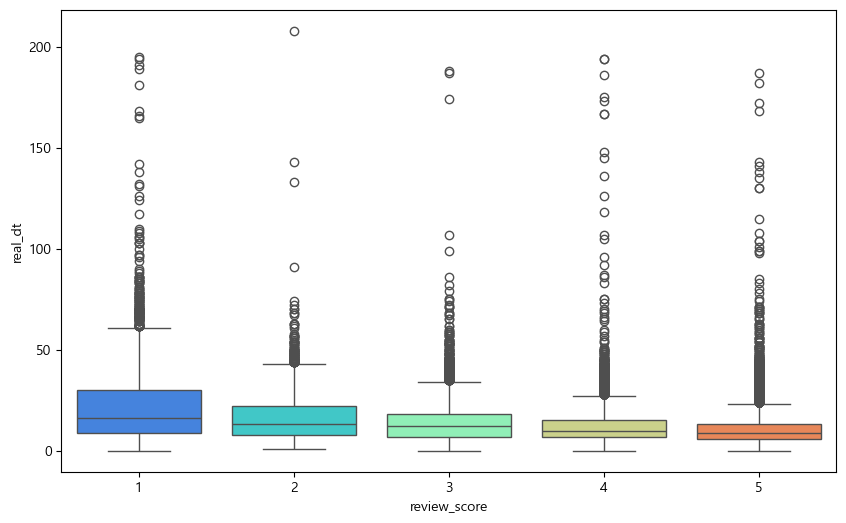

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='review_score', y='real_dt', palette='rainbow')
plt.show()

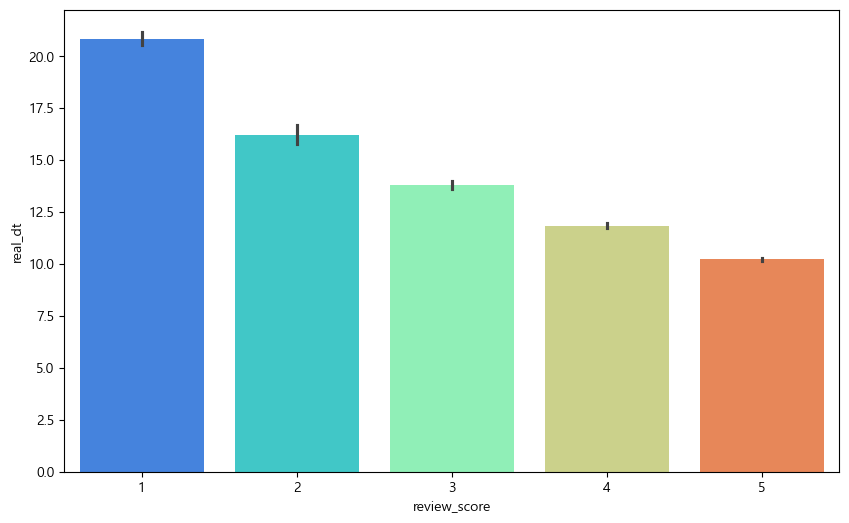

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='review_score', y='real_dt', palette='rainbow')
plt.show()

시각적으로 확인하면 리뷰 점수가 낮은 집단에서 평균 배송 기간이 길어지는 것을 확인할 수 있습니다. 일종의 선형적 관계가 있다고도 볼 수 있습니다. 이를 정확하게 확인하기 위해 통계적 분석을 시행하여 통계적 차이가 있는지 확인하였습니다.

In [24]:
def kruskal_test(data, target_column, label_column):
  labels = data[label_column].unique()
  data_list = []
  for label in labels:
    data_list.append(data[data[label_column] == label][target_column])
  stat, p_value = stats.kruskal(*data_list)
  print(f"""
  ==================================
  Kruskal-Wallis 결과
  ==================================
  p-value: {p_value:3f}
  ==================================
  {('검정 결과가 통계적으로 유의함'if p_value < 0.05 else '검정 결과가 통계적으로 유의하지 않음')}
  ==================================

  ==================================
  사후검정""", end='')
  dunn_result = sp.posthoc_dunn(df, val_col=target_column,
                              group_col=label_column, p_adjust='bonferroni')

  for index, row in dunn_result.iterrows():
    print(f"""
  ==================================
  {index}와 다른 항목
  """, end='')
    for i, p in enumerate(row):
      if p < 0.05:
        print(f"{i+1} p-value: {p:3f}", end=', ')

In [25]:
levene_stat(df, 'review_score', 'real_dt')
shapiro_stat(df, 'review_score', 'real_dt')
kruskal_test(df, 'real_dt', 'review_score')


  등분산 검정 결과
  p-value: 0.000000
  귀무가설을 기각
  

  정규성 검정 결과
  정규 분포가 아닌 집단이 존재함
  

  Kruskal-Wallis 결과
  p-value: 0.000000
  검정 결과가 통계적으로 유의함

  사후검정
  1와 다른 항목
  2 p-value: 0.000000, 3 p-value: 0.000000, 4 p-value: 0.000000, 5 p-value: 0.000000, 
  2와 다른 항목
  1 p-value: 0.000000, 3 p-value: 0.000000, 4 p-value: 0.000000, 5 p-value: 0.000000, 
  3와 다른 항목
  1 p-value: 0.000000, 2 p-value: 0.000000, 4 p-value: 0.000000, 5 p-value: 0.000000, 
  4와 다른 항목
  1 p-value: 0.000000, 2 p-value: 0.000000, 3 p-value: 0.000000, 5 p-value: 0.000000, 
  5와 다른 항목
  1 p-value: 0.000000, 2 p-value: 0.000000, 3 p-value: 0.000000, 4 p-value: 0.000000, 

검정 결과 리뷰 점수에 따라 배송 기간의 차이가 유의미하게 존재하고 있음을 확인하였습니다. 하지만 배송의 기간이 길어지더라도 좋은 리뷰를 준 경우 역시 존재하기 있으며 반대로 배송 기간이 짧아져도 나쁜 리뷰 점수를 준 경우 역시 존재합니다. 따라서 부정적인 리뷰의 더 결정적인 이유가 존재하고 있을 것이라고 생각하였습니다.

## 배송 예측의 부정확성

olist 데이터 셋은 실제 배송 기간이 아닌 예상 배송기간 역시 제시해주고 있습니다. 여기서 배송 예측의 부정확성이 리뷰 점수의 저하로 이어질 수 있다는 가설을 새워보았습니다. 먼저 배송 예측이 부정확하다는 사실을 확인해 보았습니다.

estimated_dt    23.377948
real_dt         12.058447
dtype: float64


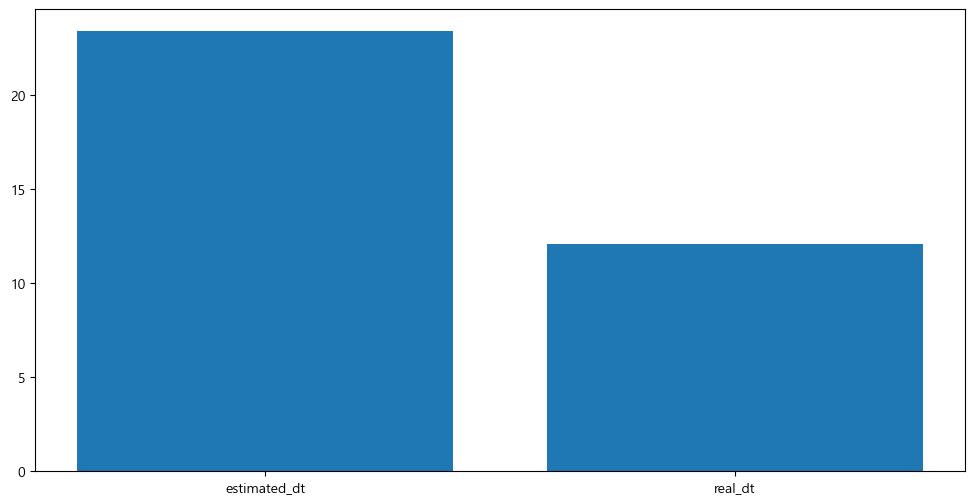

In [26]:
df_bar = df[['estimated_dt', 'real_dt']].mean()
print(df_bar)
plt.bar(df_bar.index, df_bar.values)
plt.show()

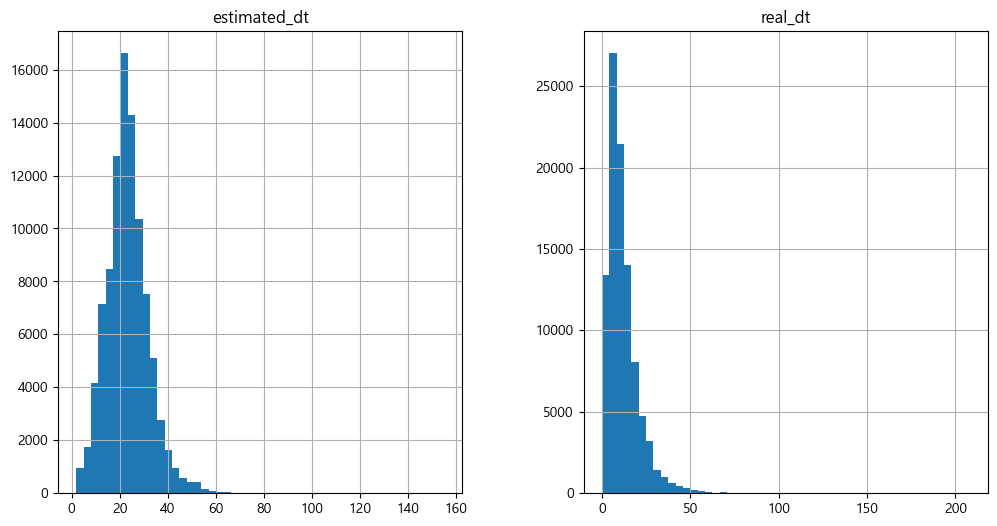

In [27]:
df[['estimated_dt', 'real_dt']].hist(bins = 50, figsize=(12, 6))
plt.show()

11.319500954911566


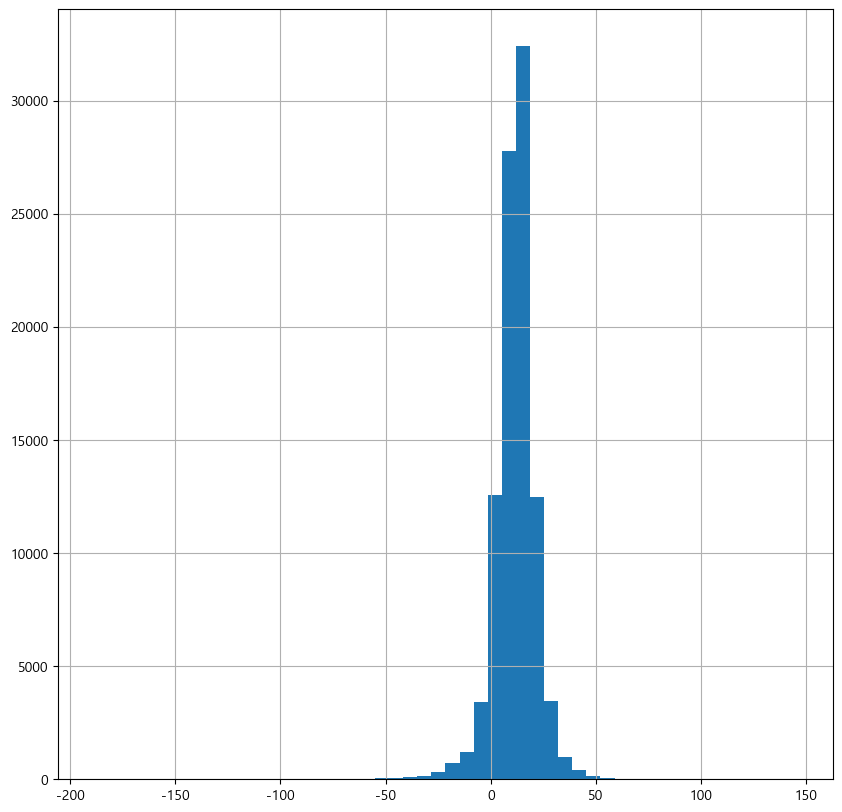

In [28]:
print(df['dd'].mean())
df['dd'].hist(bins = 50, figsize=(10, 10))
plt.show()

예측 모델은 데이터를 평균 22일을 기준으로 정규 분포에 가까운 분포를 보이는 반면, 실제 배송 시간은 평균 9일로 왼쪽으로 치우처진 긴꼬리 분포의 모양을 보입니다. 배송 예상 시간과 실제 배송시간의 차이는 12일 정도로 상당히 보수적으로 예측하고 있는 것을 확인 할 수 있었습니다. 문제는 배송 예측이 상당히 보수적으로 이루어지고 있음에도, 배송 지연이 발생하는 경우가 있었다는 것입니다. 이는 배송 예측 모델이 정확하지 않다는 사실을 설명한다고도 말할 수 있습니다.

## 배송 지연에 따른 불만족

모델의 부정확성으로 인해 발생하는 지연으로 인해 어떤 문제가 발생할 수 있는지도 확인해 보았습니다.

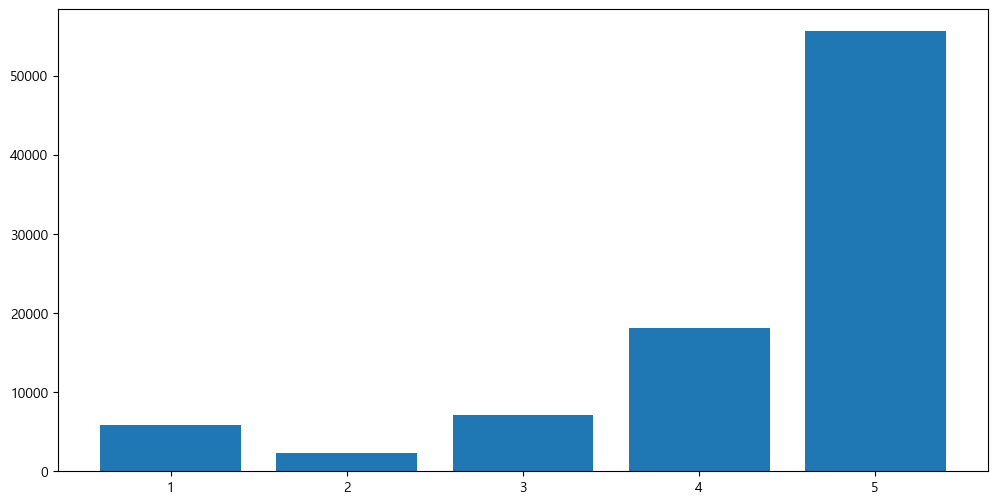

In [29]:
df_2 = df[df['dd'] >= 0]
df_2_bar = df_2.groupby("review_score").size()
plt.bar(df_2_bar.index, df_2_bar.values)
plt.show()

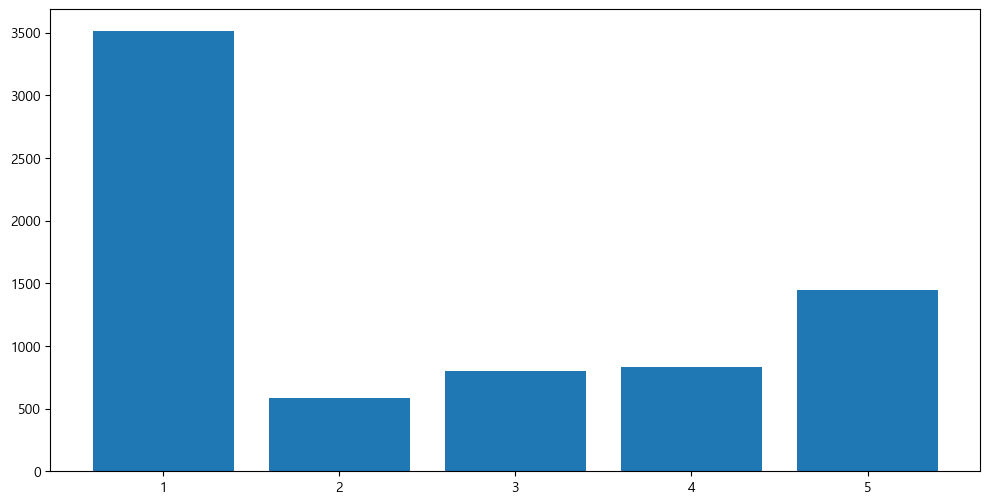

In [30]:
df_1 = df[df['dd'] < 0]
df_1_bar = df_1.groupby("review_score").size()
plt.bar(df_1_bar.index, df_1_bar.values)
plt.show()

In [31]:
def chi_square_test(df, x_columns, y_columns):
  df_crosstab = pd.crosstab(df[x_columns], df[y_columns])
  chi2, pval, dof, expected = stats.chi2_contingency(df_crosstab)

  print(f"""
  ==================================
  Chi-squared 검정 결과
  ==================================
  p-value: {pval:2f}
  ==================================
  효과 크기: {
      np.sqrt(
          chi2 / (
              len(df) * min(
                  len(df[x_columns].unique())-1,
                  len(df[y_columns].unique())-1
                  )
              )
          )
      :2f}
  ==================================
  {('검정 결과가 통계적으로 유의함'if pval < 0.05 else '검정 결과가 통계적으로 유의하지 않음')}
  ==================================
  """)

In [32]:
df['dd_g'] = 0
df.loc[df['dd'] >= 0, 'dd_g'] = 1
chi_square_test(df, 'dd_g', 'review_score')


  Chi-squared 검정 결과
  p-value: 0.000000
  효과 크기: 0.396612
  검정 결과가 통계적으로 유의함
  


효과 크기는 약한 효과만 존재한다고 설명하지만 시각화된 그래프에서 지연의 효과가 특히 1점 대에서 크게 나타나고 있음을 확인해주고 있습니다. 이는 배송 예측 시스템으로 인해 나타난 배송의 지연이 부정적 리뷰를 만들어 내는 원인이 될 수도 있다는 사실을 말해주고 있습니다.

## 배송 지연 정도에 따른 리뷰 만족도 효과 확인

- ord_df['dd'] = ord_df['estimated_dt'] - ord_df['real_dt']
- 0보다 크면 배송 미지연
- 0보다 작으면 배송 지연

df['dd_g'] = 0 # 지연 시 'dd_g'=0
df.loc[df['dd'] >= 0, 'dd_g'] = 1 # 미지연 시 'dd_g'=1
chi_square_test(df, 'dd_g', 'review_score')

olist_orders_dataset['real_dt'] = olist_orders_dataset.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_delivered_customer_date']
    ),
    axis=1
)
#### 실제 고객이 받은 시간 - 구매 시간

In [ ]:
df_late = df[df['dd_g'] == 0].copy() #지연된 데이터만!
df_late['dd_g'] = pd.qcut(df_late['dd'], q=5, labels=['1','2','3','4','5'], duplicates='drop')
df_late['dd_g'].value_counts()

dd_g
4    1681
2    1641
1    1450
3    1276
5    1135
Name: count, dtype: int64

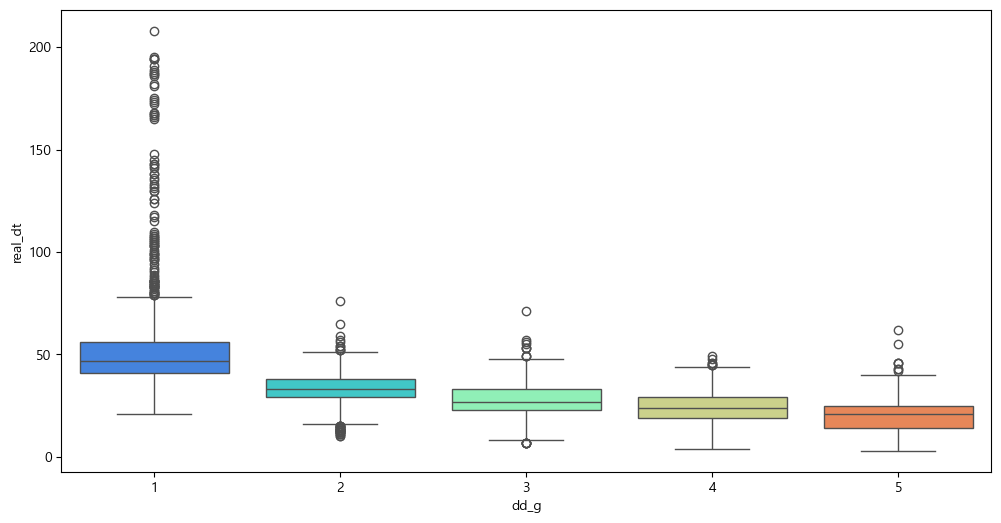

In [34]:
sns.boxplot(data=df_late, x='dd_g', y='real_dt', palette='rainbow')
plt.show()

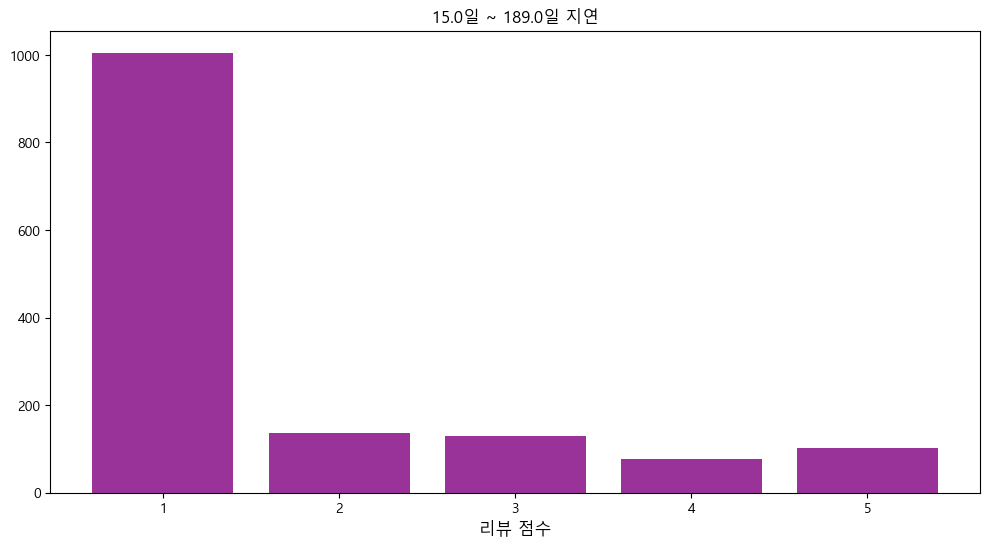

In [55]:
df_1 = df_late[df_late['dd_g'] == '1']
df_1_bar = df_1.groupby("review_score").size()
plt.bar(df_1_bar.index, df_1_bar.values, color='purple', alpha=0.8)
plt.title(f"{abs(df_1['dd'].max())}일 ~ {abs(df_1['dd'].min())}일 지연")
# 축 라벨과 제목 설정
plt.xlabel("리뷰 점수", fontsize=12)
plt.show()

-8.0 ~ -14.0


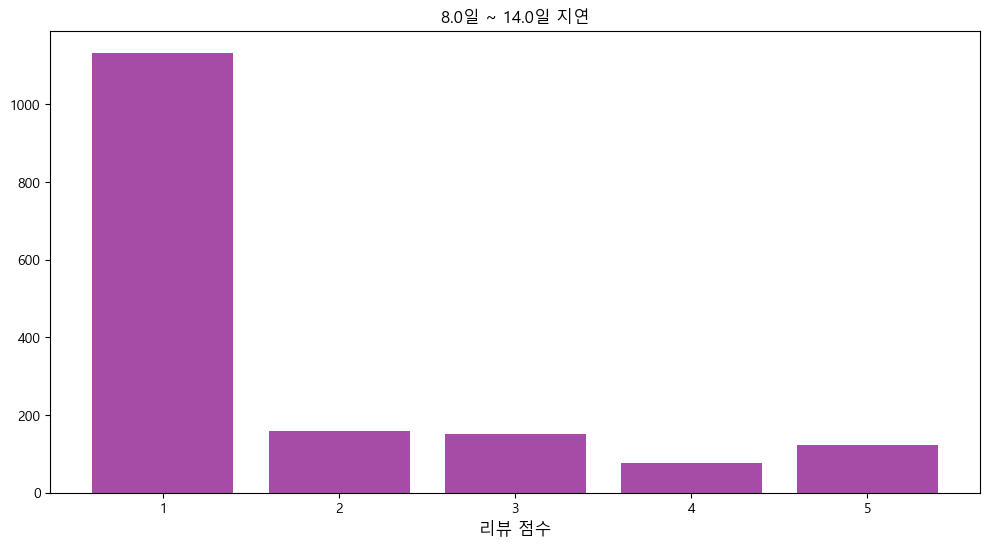

In [53]:
df_2 = df_late[df_late['dd_g'] == '2']
print(f"{df_2['dd'].max()} ~ {df_2['dd'].min()}")
df_2_bar = df_2.groupby("review_score").size()

plt.bar(df_2_bar.index, df_2_bar.values, color='purple', alpha=0.7)
plt.title(f"{abs(df_2['dd'].max())}일 ~ {abs(df_2['dd'].min())}일 지연")
# 축 라벨과 제목 설정
plt.xlabel("리뷰 점수", fontsize=12)
plt.show()

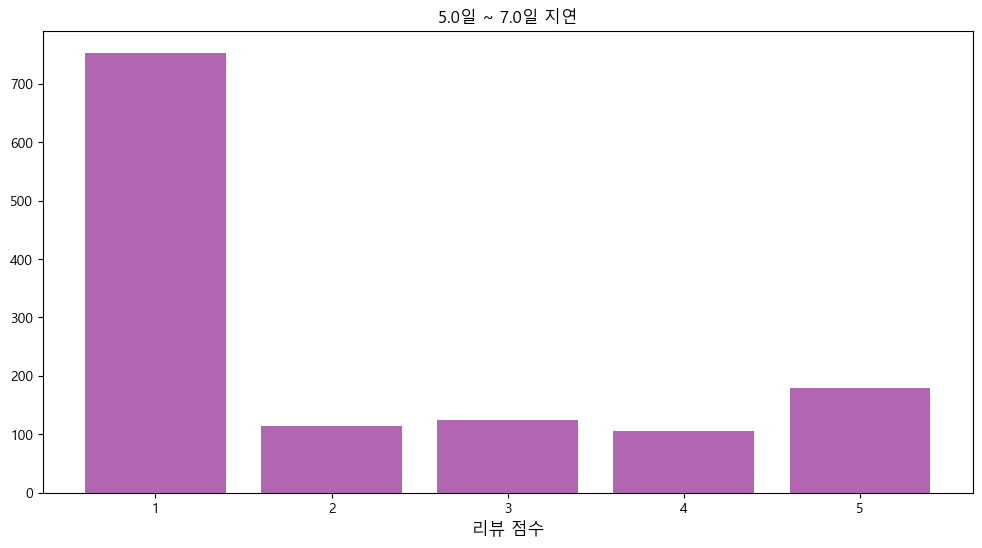

In [56]:
df_3 = df_late[df_late['dd_g'] == '3']
df_3_bar = df_3.groupby("review_score").size()
plt.bar(df_3_bar.index, df_3_bar.values, color='purple', alpha=0.6)
plt.title(f"{abs(df_3['dd'].max())}일 ~ {abs(df_3['dd'].min())}일 지연")
plt.xlabel("리뷰 점수", fontsize=12)
plt.show()

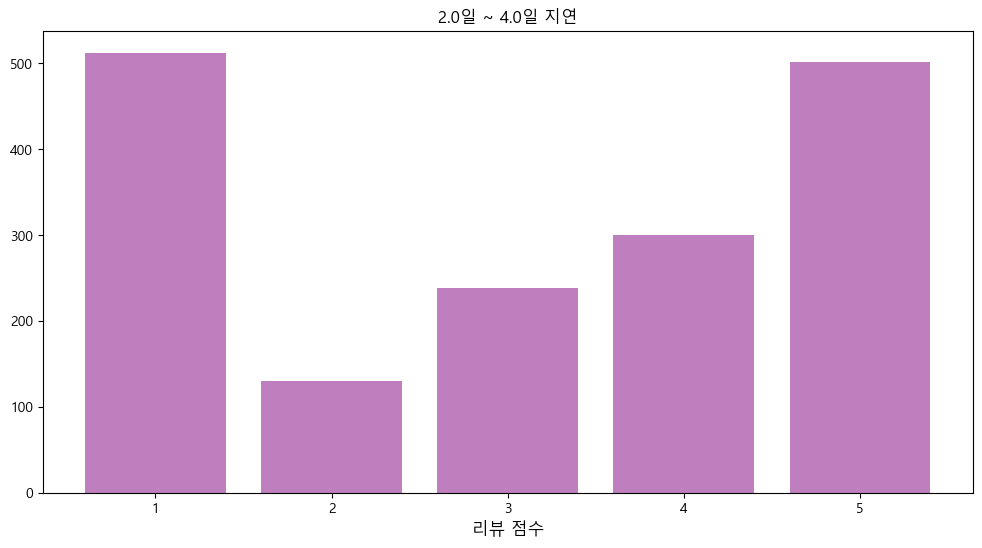

In [57]:
df_4 = df_late[df_late['dd_g'] == '4']
df_4_bar = df_4.groupby("review_score").size()
plt.bar(df_4_bar.index, df_4_bar.values, color='purple', alpha=0.5)
plt.title(f"{abs(df_4['dd'].max())}일 ~ {abs(df_4['dd'].min())}일 지연")
plt.xlabel("리뷰 점수", fontsize=12)
plt.show()

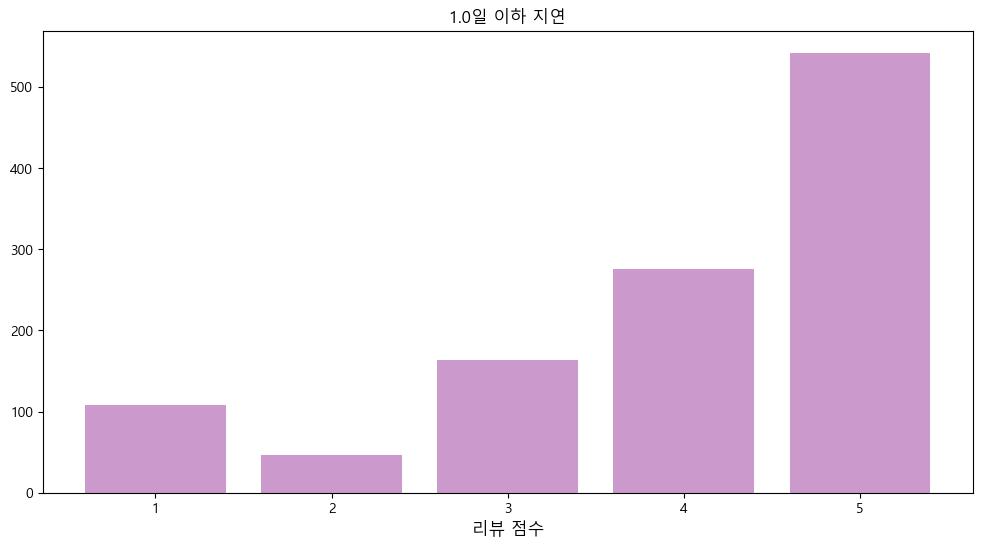

In [58]:
df_5 = df_late[df_late['dd_g'] == '5']
df_5_bar = df_5.groupby("review_score").size()
plt.bar(df_5_bar.index, df_5_bar.values, color='purple', alpha=0.4)
plt.title(f"{abs(df_5['dd'].max())}일 이하 지연")
plt.xlabel("리뷰 점수", fontsize=12)
plt.show()

<BarContainer object of 5 artists>

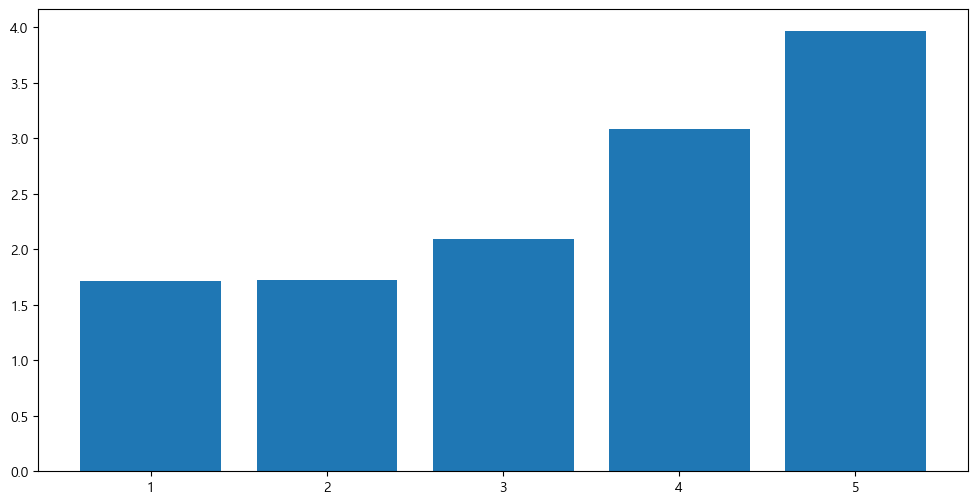

In [40]:
plt.bar(
    df_late.groupby('dd_g')['review_score'].mean().index,
    df_late.groupby('dd_g')['review_score'].mean().values
    )

df['dd_g'] = 0 # 지연 시 'dd_g'=0
df.loc[df['dd'] >= 0, 'dd_g'] = 1 # 미지연 시 'dd_g'=1
df_late = df[df['dd_g'] == 0].copy() #지연된 데이터만!

In [41]:
chi_square_test(df_late, 'dd_g', 'review_score')


  Chi-squared 검정 결과
  p-value: 0.000000
  효과 크기: 0.260993
  검정 결과가 통계적으로 유의함
  


지연이 충분히 리뷰 만족도 저하에 효과가 있음을 확인하였다면, 이제 어느정도의 지연이 리뷰 만족도를 극도로 저하시키는지 확인해야 합니다. 데이터를 지연 일수에 따라 5개의 집단으로 나누어 확인하였을 때, 지연 2일 째 부터 리뷰만족도에 영향을 미치기 시작하며, 3일 이후 부터는 리뷰 만족도에서 1점 리뷰가 극도로 증가하는 모습을 관측할 수 있었습니다. 따라서 보수적인 리뷰를 가정한다면 가능한 지연이 최대 2일로 한정되어야 합니다.

## 지역에 따른 배송 시간 소요

olist_order_reviews_dataset_new = olist_order_reviews_dataset[['order_id', 'new_score', 'review_score']]

df = pd.merge(olist_orders_dataset, olist_order_reviews_dataset_new, on='order_id', how='inner')
df['dd_g'] = 0 # 지연 시 'dd_g'=0
df.loc[df['dd'] >= 0, 'dd_g'] = 1 # 미지연 시 'dd_g'=1

In [42]:
df_r = pd.merge(df, olist_customers_dataset, on='customer_id', how='inner')

In [43]:
df_bar = (
    df_r[df_r['dd_g']==0].
    groupby('customer_state').size()
    /
    df_r.
    groupby('customer_state').size()
    *
    100
    ).dropna().sort_values(ascending=False)

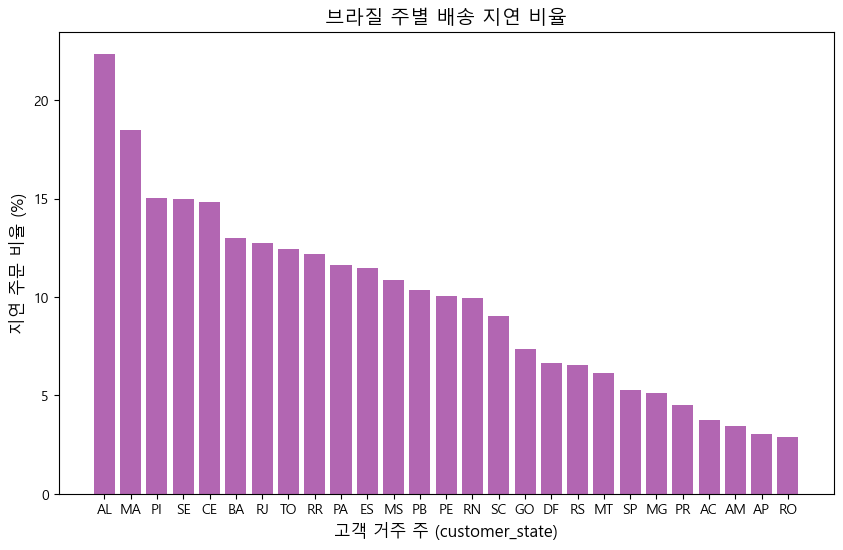

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(df_bar.index, df_bar.values, color='purple', alpha=0.6)

plt.title("브라질 주별 배송 지연 비율", fontsize=14)
plt.xlabel("고객 거주 주 (customer_state)", fontsize=12)
plt.ylabel("지연 주문 비율 (%)", fontsize=12)

plt.show()


주별 주문 밀도

# 결론

배송은 리뷰에 직간접적 영향을 주는 요인이라고 설명할 수 있습니다. 특히 배송의 지연은 리뷰에 부정적인 영향을 끼칠 가능성이 높습니다. 효과 크기가 낮다고 하더라도 1점 혹은 5점으로 편향된 리뷰가 나타날 수 밖에 없는 이커머스 환경에서 1점의 증가는 실질적인 부정 의견의 증가로도 볼 수 있기 때문입니다.

문제는 기존 배송 모델이 상당히 보수적으로 예측을 시행하고 있다는 데 있습니다. 예측 모델은 10일 정도 느리게 도착할 것이라 예측하고 있습니다. 그러나 보수적인 모델에서도 지연이 발생하고, 그로 인해 불만족이 발생하고 있었습니다. 따라서 기존 모델의 정확도를 개선할 필요가 있음을 확인할 수 있습니다.

그러나 보수적 예측 자체가 가저오는 효용이 있다는 것 역시 확인할 수 있었습니다. 기존 모델이 보수적 예측을 통해 부정확한 예측에서 오는 지연을 방지하였고, 동시에 기존 예측보다 일찍 도착하는 결과를 통하여 고객의 만족을 유도한 것입니다. 따라서 모델을 구성한다면, 정확한 예측 모델을 구성하되 실제 출력에서 예상 시간 혹은 날짜를 더하는 등, 보수적 예측을 하도록하는 것이 더 좋을 것입니다.